The notebook provides an overview of three datasets provided in the Zillow Prize competition: https://www.kaggle.com/c/zillow-prize-1  

## Background
Zillow is the leading real estate and rental marketplace dedicated to empowering consumers with data, inspiration and knowledge around the place they call home, and connecting them with the best local professionals who can help.  
The Zestimate® home valuation is Zillow's estimated market value, computed using a proprietary formula. It is not an appraisal. It is a starting point in determining a home's value. The Zestimate is calculated from public and user-submitted data, taking into account special features, location, and market conditions.   


## Competition
In the public round, two datasets are provided:  
1. train_2016_v2.csv  
The training set has all the transactions from 1/1/2016 to 12/31/2016  
Parcelid: parcel (property) identification code   
logerror: the log error between their Zestimate and the actual sale price   
The log error is defined as log error=log(Zestimate)−log(SalePrice)  
transactiondate: transaction date

2. properties_2016.csv  
a full list of real estate properties in three counties (Los Angeles, Orange and Ventura, California) with their home features for 2016. Some 2017 new properties don't have any data yet except for their parcelid's. 

In this competition, Zillow is asking participants to predict the log error between their Zestimate and the actual sale price, given all the features of a home. There are 6 time points to predict for all properties: October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712)

### Import required modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

### Load the data file: train_2016_v2.csv

In [2]:
trans = pd.read_csv('/Users/user/Documents/BentleyCourses/Zillow/train_2016_v2.csv',parse_dates=['transactiondate'],dtype={'parcelid': object})
trans.shape

(90275, 3)

In [3]:
trans.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [4]:
# check data types
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90275 entries, 0 to 90274
Data columns (total 3 columns):
parcelid           90275 non-null object
logerror           90275 non-null float64
transactiondate    90275 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.1+ MB


### How many unique houses are there?
Most houses were sold once and some were sold twice

In [5]:
trans['parcelid'].value_counts().reset_index()['parcelid'].value_counts()

1    90026
2      123
3        1
Name: parcelid, dtype: int64

### What is the time frame?

In [6]:
print(trans['transactiondate'].min(), " to ", trans['transactiondate'].max())

2016-01-01 00:00:00  to  2016-12-30 00:00:00


### How many transactions for each month?
The following code shows that houses were sold mostly from March to September while in Novemeber and Decemebr, there were limited transactions.

In [7]:
# create the month from the transaction date
trans['transactionmonth'] = trans['transactiondate'].dt.month

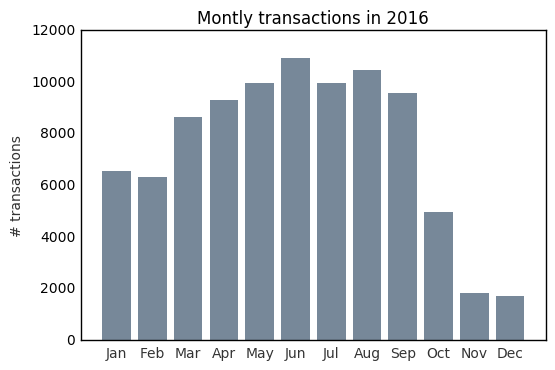

In [8]:
mth_cnt = trans['transactionmonth'].value_counts(dropna=False)

plt.bar(mth_cnt.index,mth_cnt.values,align='center',linewidth=0, color='lightslategrey')
plt.xlim(0,13)
plt.ylabel('# transactions',alpha=.8)
plt.title('Montly transactions in 2016')

plt.xticks(mth_cnt.index.sort_values(), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],alpha=.8)
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', labelbottom='on')

plt.show()

### Discussion of the prediction error    
**1. Why does Zillow want to predict the prediction error instead of the actual sales price?**  
Zillow expect participants to capture additional signals that their current model has not exploited.  

**2. Why does Zillow pick the log error instead of an absolute error metric such as RMSE?**  
Firstly, home sale prices have a right skewed distribution and are also strongly heteroscedastic, so we need to use a relative error metric instead of an absolute metric to ensure valuation models are not biased towards expensive homes. A relative error metric like the percentage error or log ratio error avoids these problems.  

Furthermore, the choice of the natural logarithm indicates a heavier penalty to predictions that underestimate the sale price.

**3. Even though the log error metric seems reasonable, it is not intuitively easy to understand. Therefore, the error is converted from the logarithmic form to the exponential form as follows**  
log-error = log(Zestimate)−log(SalePrice)
so, eror = Zestimate/SalePrice = 10^(log-error)

Reference: https://www.kaggle.com/c/zillow-prize-1/discussion/33899

In [9]:
trans['error'] = np.power(math.e, trans['logerror'])
trans.head()

,parcelid,logerror,transactiondate,transactionmonth,error
0,11016594,0.0276,2016-01-01,1,1.027984
1,14366692,-0.1684,2016-01-01,1,0.845016
2,12098116,-0.0040,2016-01-01,1,0.996008
3,12643413,0.0218,2016-01-02,1,1.022039
4,14432541,-0.0050,2016-01-02,1,0.995012


In [10]:
trans['error'].describe()

count    90275.000000
mean         1.032591
std          0.711017
min          0.010002
25%          0.975017
50%          1.006018
75%          1.039978
max        114.091414
Name: error, dtype: float64

Most of the errors are 1 approximately, meaning Zestimate does a fairly good work. However, there are significantly large values. We will look at boxplots to visualize the errors.

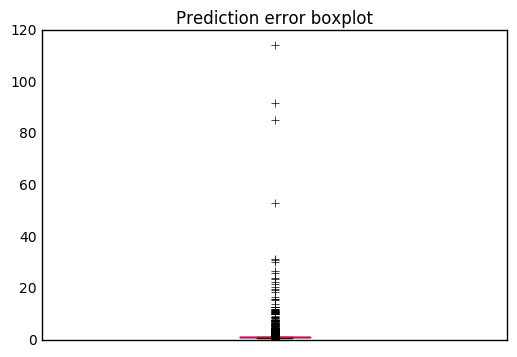

In [11]:
plt.boxplot(trans['error'], notch=False)
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', labelbottom='off')
plt.title('Prediction error boxplot')
plt.show()
# https://matplotlib.org/examples/pylab_examples/boxplot_demo.html

Again, the boxplot shows that outliers can be 20 up to 120. That's why the y-axis has to expand and it's hard to see where most the values lie. So, we will create a boxplot that remove those outliers.  
Note: some outliers can be an error, some can be valid values. We will come back later to see in what cases outliers in the dataset are.

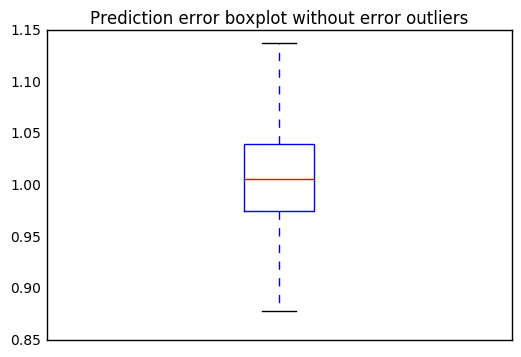

In [12]:
# don't show outlier points
plt.boxplot(trans['error'], showfliers=False)
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', labelbottom='off')
plt.title('Prediction error boxplot without error outliers')
plt.show()

This boxplot confirms that most of the errors lie between from 0.85 and 1.15

### Are prediction errors impacted by seasonal factors?
The follwing chart shows that predictions seem to more correct in the middle period of the year, but the difference is not significant.

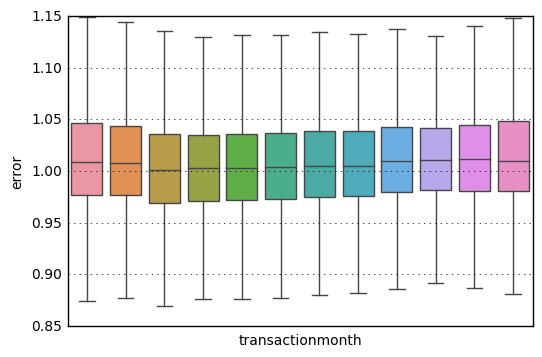

In [13]:
fig, ax = plt.subplots()
sns.boxplot(x='transactionmonth', y='error', data=trans, showfliers=False)
### ADD MONTHS on the x-axis # plt.xticks(mth_cnt.index.sort_values(), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],alpha=.8)
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', labelbottom='off')
ax.yaxis.grid(True)
plt.show()

### Load data file: properties_2016.csv

In [14]:
properties = pd.read_csv('/Users/user/Documents/BentleyCourses/Zillow/properties_2016.csv',dtype={'parcelid':object})

/Users/user/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
properties.shape

(2985217, 58)

In [16]:
len(properties.parcelid.unique())

2985217

This dataset has 2,985,217 unique properties and 57 features related to the properties. The transaction dataset only has 90,150 properties so the rest (2,895,067 properties) do not have any transaction records and thus, no prediction errors as well.

In [17]:
properties.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [18]:
# check data types
properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 58 columns):
parcelid                        object
airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
hashottu

A few changes for the dataset:
Year-related variables should be integer: assessmentyear 

### Missing data
There seems to be missing values in the dataset. Let's check how many missing values for each variable

In [19]:
totalcnt = len(properties)
missing = properties.isnull().sum(axis=0).reset_index()
missing.columns = ['variable','missing_cnt']
missing =missing.drop(missing['variable']=='parcelid')
missing['missing_percent'] = missing['missing_cnt']/totalcnt
missing.sort_values(by='missing_percent',inplace=True, ascending=False)
missing.head()

,variable,missing_cnt,missing_percent
41,storytypeid,2983593,0.999456
3,basementsqft,2983589,0.999455
46,yardbuildingsqft26,2982570,0.999113
49,fireplaceflag,2980054,0.998270
2,architecturalstyletypeid,2979156,0.997970


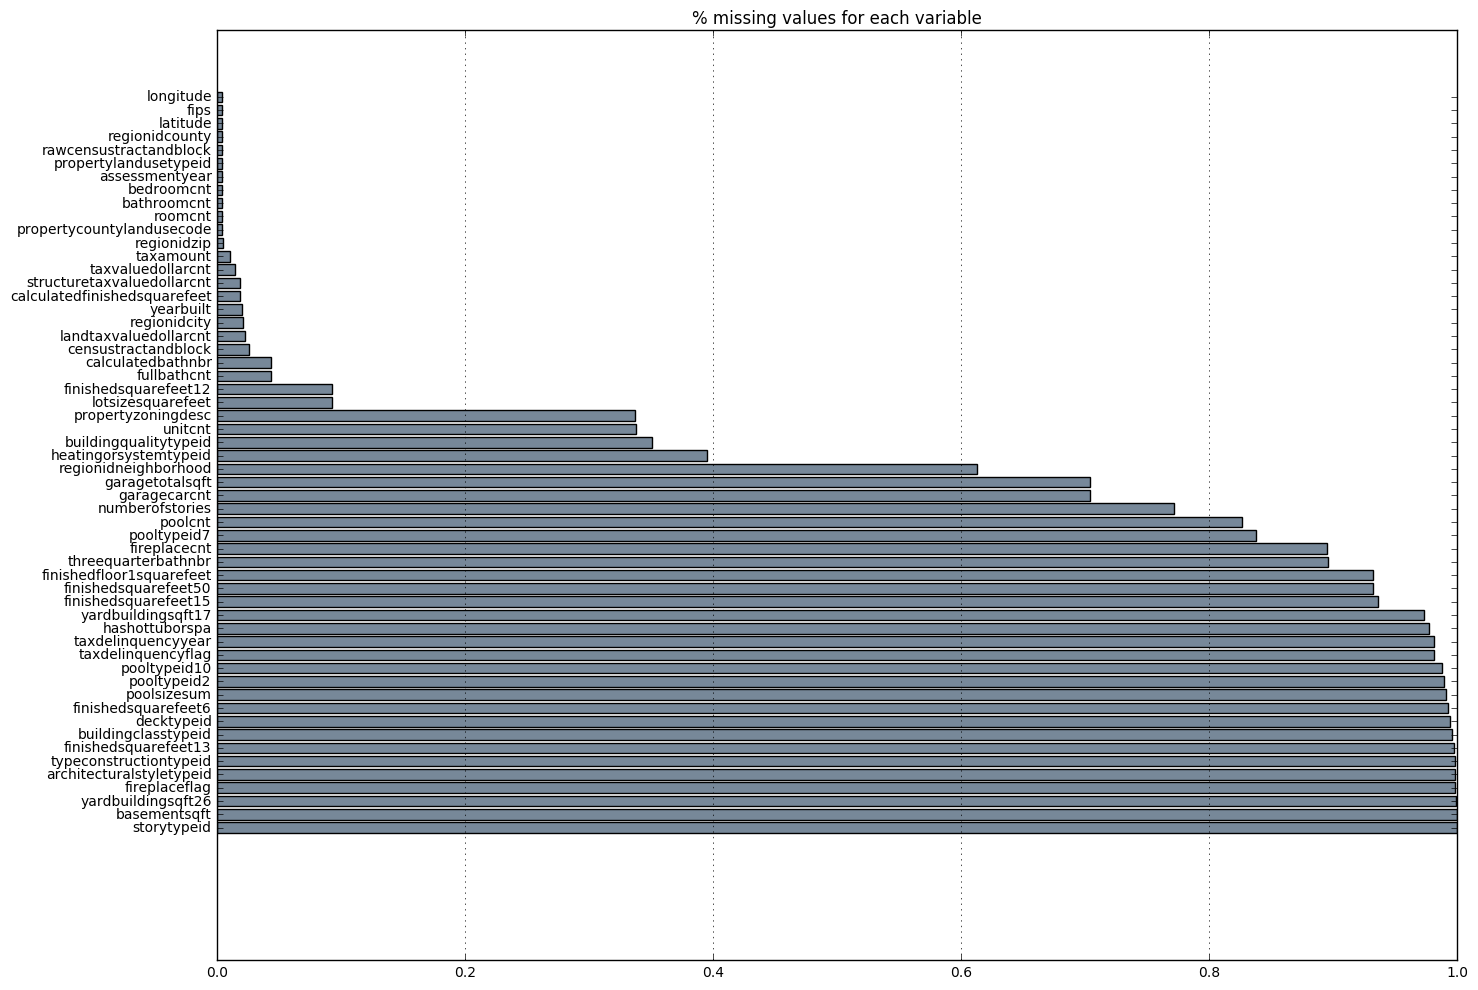

In [20]:
# create a horizontal bar chart
fig, ax = plt.subplots(figsize=(16,12))
ind = np.arange(missing.shape[0])
plt.barh(ind, missing['missing_percent'], align='center', color='lightslategrey')
ax.set_yticks(ind)
ax.set_yticklabels(missing['variable'], rotation='horizontal')
plt.title('% missing values for each variable')
ax.xaxis.grid(True)
plt.show()
# https://matplotlib.org/devdocs/gallery/lines_bars_and_markers/barh.html

In [21]:
# create bins to group the missing severity
bins = [0,0.2,0.4,0.6,0.8,0.9,0.95,0.99,1]
group_names = ['<20%','20%-40%','40%-60%','60%-80%','80%-90%','90%-95%','95%-99%','99%-100%']
missing['missing_group']=pd.cut(missing['missing_percent'],bins,labels=group_names)
missing.groupby('missing_group')['variable'].count()

missing_group
<20%        24
20%-40%      4
40%-60%      0
60%-80%      4
80%-90%      4
90%-95%      3
95%-99%      6
99%-100%    11
Name: variable, dtype: int64

Out of 57 variables, 24 variables have less than 20% missing values, 20 variables have greater than 90% missing values.

### Load file: sample_submission.csv

In [22]:
submission = pd.read_csv('/Users/user/Documents/BentleyCourses/Zillow/sample_submission.csv')
submission.shape

(2985217, 7)

In [23]:
submission.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0
3,10859147,0,0,0,0,0,0
4,10879947,0,0,0,0,0,0


In [24]:
len(submission.ParcelId.unique())

2985217

We need to predict all properties at 6 time points because we don't know whether and when the properties are sold.

The public leaderboard is based on the prediction of 201610, 201611, and 201612. The public leaderboad is for participants to measure their models against each other.   
The private leaderboard is based on the prediction of 201710, 201711, 201712 and the final scoring will be for only the these last 3 time points.  

if the property is already in the training set (meaning that it was sold in 2016), it's ignored in the public leaderboard. We do ask you to predict that number because we want to enforce the structure of predicting all the properties for all the time points.

Reference:  
https://www.kaggle.com/c/zillow-prize-1/discussion/33899  
https://www.kaggle.com/c/zillow-prize-1/discussion/39073  

## Check parcelid in three data sets

In [25]:
set(trans.parcelid) - set(properties.parcelid)

set()

All parcelid in train_2016_v2.csv are in properties.csv

In [27]:
set(properties.parcelid) - set(submission.ParcelId)

{'12329010',
 '11196048',
 '10948145',
 '12080784',
 '14216896',
 '12718044',
 '14000970',
 '12478626',
 '12187442',
 '12954813',
 '12656772',
 '14107961',
 '10769743',
 '12016608',
 '13962092',
 '14455338',
 '12236338',
 '12040437',
 '10948242',
 '12743313',
 '12808583',
 '12341221',
 '17215611',
 '14202830',
 '11687241',
 '17226007',
 '12382350',
 '12885611',
 '12250555',
 '13059611',
 '12097455',
 '11941196',
 '11025908',
 '11080822',
 '12267384',
 '11659584',
 '11162531',
 '17071248',
 '12473321',
 '11717318',
 '17127379',
 '12570020',
 '13931063',
 '11043830',
 '14499887',
 '14526106',
 '12650357',
 '11049701',
 '11560230',
 '13130895',
 '12516073',
 '11002029',
 '14622031',
 '11192628',
 '12176946',
 '11860786',
 '10877897',
 '13871189',
 '10902033',
 '13100182',
 '12859157',
 '10754733',
 '14364089',
 '14490193',
 '10859915',
 '12259302',
 '14115543',
 '12593579',
 '12059385',
 '12187802',
 '12497190',
 '14698326',
 '11708477',
 '11151756',
 '11691607',
 '10723861',
 '11528560',

In [28]:
set(submission.ParcelId) - set(properties.parcelid)

{168040141,
 168040144,
 168040145,
 168040146,
 168040151,
 168040154,
 168040155,
 168040156,
 168040157,
 168040158,
 168040159,
 168040160,
 168040161,
 168040162,
 168040163,
 168040164,
 168040165,
 168040166,
 168040168,
 168040169,
 168040170,
 168040171,
 168040172,
 168040173,
 168040174,
 168040175,
 168040176,
 168040177,
 168040178,
 168040179,
 168040180,
 168040181,
 168040182,
 168040184,
 168040185,
 168040186,
 168040187,
 168040188,
 168040189,
 168040190,
 168040191,
 168040194,
 168040195,
 168040196,
 168040197,
 168040198,
 168040199,
 168040200,
 168040201,
 168040202,
 168040203,
 168040204,
 168040205,
 168040206,
 168040207,
 168040208,
 168040209,
 168040210,
 168040211,
 168040212,
 168040213,
 168040214,
 168040215,
 168040216,
 168040217,
 168040218,
 168040219,
 168040220,
 168040221,
 168040222,
 168040228,
 168040231,
 168040232,
 168040233,
 168040234,
 168040235,
 168040236,
 168040241,
 168040245,
 168040246,
 168040247,
 168040248,
 168040249,
 168